In [1]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
import src.utils.presenter as show
import src.utils.visualization.gantt_diagram as gantt
from src.utils.initialization import jobs_jssp_init as init, gen_deadlines__prototype as gen_deadline
from src.utils.analysis_basics import check_constrains as check

# Solver Model
import src.models.heuristics.fcfs as fcfs

# Extern
import pandas as pd

pd.set_option('display.max_rows', 21)

In [2]:
basic_data_path = get_path("data", "basic")
day_count = 1

df_instance = pd.read_csv(basic_data_path / "instance.csv")
df_jssp, df_job_arrivals = init.create_production_orders_for_shifts(df_template=df_instance, shift_count=day_count,
                                                                 u_b_mmax= 0.94, shift_length=1440, shuffle=True,
                                                                 job_seed=40, arrival_seed=80)

df_jobs_times = gen_deadline.get_times_df(df_jssp, df_job_arrivals, fcfs.schedule_with_arrivals, target_service=1.0)
df_jobs_times['Ready Time'] = ((df_jobs_times['Arrival'] // 1440) + 1) * 1440

df_jobs_times["Deadline"] = df_jobs_times["Deadline"] + 900
df_jobs_times


Schedule-Informationen:
  Makespan: 2400


,Job,Production_Plan_ID,Arrival,Deadline,Ready Time
0,0,0,49,1748.0,1440
1,1,1,130,2062.0,1440
2,2,2,151,2200.0,1440
3,3,3,226,2451.0,1440
4,4,4,386,2081.0,1440
5,5,5,464,2367.0,1440
6,6,6,480,2222.0,1440
7,7,7,506,2496.0,1440
8,8,8,526,2634.0,1440
9,9,9,535,2527.0,1440


In [4]:
#df_jobs_times = gen_deadline.assign_deadlines_with_global_lognormal_mode(df_jobs_times, sigma=0.5, 
#                                                                         basic_slack=60, seed=50, global_modus=2880)
#
#df_jobs_times

,Job,Arrival,Ready Time,Processing Time,Earliest End,Deadline
0,Job_000,0,1440,395,1835,2657
1,Job_001,48,1440,510,1950,6622
2,Job_002,113,1440,568,2008,2102
3,Job_003,157,1440,655,2095,5590
4,Job_004,198,1440,393,1833,2953
...,...,...,...,...,...,...
34,Job_034,2524,2880,597,3477,3972
35,Job_035,2534,2880,496,3376,3647
36,Job_036,2542,2880,393,3273,4922
37,Job_037,2606,2880,539,3419,5806


In [5]:
import pandas as pd


def giffler_thompson_schedule(
    df_jssp: pd.DataFrame,
    df_arrivals_deadlines: pd.DataFrame,
    priority_rule: str = "SPT",
    log_on: bool = True
) -> pd.DataFrame:
    """
    Giffler-Thompson-Algorithmus mit Ready Time (für Planung) und Arrival (für Ausgabe).
    Rückgabe mit Lateness, Tardiness, Earliness.

    Rückgabe:
    - df_schedule: DataFrame mit Zeitplan und Auswertung
    - makespan: maximale Endzeit
    - total_abs_lateness: Summe der absoluten Lateness der letzten Operationen je Job
    """

    if log_on: 
        print(f'Giffler-Thompson-Algorithmus mit Prioritätsregel \"{priority_rule}\" gestartet ...\n')

    df = df_jssp.copy().sort_values(['Job', 'Operation']).reset_index(drop=True)
    machines = set(df['Machine'])
    jobs = df['Job'].unique()

    ready_time = df_arrivals_deadlines.set_index("Job")["Ready Time"].to_dict()
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()

    job_op_ready = {job: 0 for job in jobs}
    machine_available = {m: 0 for m in machines}
    job_op_index = {job: 0 for job in jobs}

    job_ops = defaultdict(list)
    for _, row in df.iterrows():
        job_ops[row['Job']].append((row['Operation'], row['Machine'], row['Processing Time']))

    result = []
    remaining = sum(len(v) for v in job_ops.values())

    while remaining > 0:
        candidates = []
        for job in jobs:
            idx = job_op_index[job]
            if idx < len(job_ops[job]):
                op_id, m, d = job_ops[job][idx]
                est = max(job_op_ready[job], machine_available[m], ready_time[job])
                candidates.append((est, d, job, op_id, m))

        min_est = min(c[0] for c in candidates)
        conflict_ops = [c for c in candidates if c[0] == min_est]

        if priority_rule == "SPT":
            selected = min(conflict_ops, key=lambda x: x[1])
        elif priority_rule == "EDF" or priority_rule == "EDD":
            selected = min(conflict_ops, key=lambda x: deadline[x[2]])  # x[2] ist der Job
        else:  # RANDOM oder unbekannt
            selected = random.choice(conflict_ops)

        est, d, job, op_id, m = selected
        start = est
        end = start + d

        result.append({
            'Job': job,
            'Operation': op_id,
            'Machine': m,
            'Start': start,
            'Processing Time': d,
            'End': end
        })

        job_op_ready[job] = end
        machine_available[m] = end
        job_op_index[job] += 1
        remaining -= 1

    # Berechnung von Lateness, Tardiness, Earliness
    for row in result:
        job = row['Job']
        lateness_val = row['End'] - deadline[job]
        row.update({
            "Arrival": arrival[job],
            "Deadline": deadline[job],
            "Lateness": lateness_val,
            "Tardiness": max(0, lateness_val),
            "Earliness": max(0, -lateness_val)
        })

    df_schedule = pd.DataFrame(result).sort_values(['Start', 'Job', 'Operation']).reset_index(drop=True)

    last_ops = df_schedule.groupby("Job")["Operation"].max()
    last_op_index_tuples = list(zip(last_ops.index, last_ops.values))
    mask_last_ops = df_schedule.set_index(["Job", "Operation"]).index.isin(last_op_index_tuples)
    total_abs_lateness = df_schedule[mask_last_ops]["Lateness"].abs().sum()

    makespan = df_schedule['End'].max()

    if log_on:
        print("\nPlan-Informationen:")
        print(f"  Anzahl Jobs            : {len(jobs)}")
        print(f"  Anzahl Maschinen       : {len(machines)}")
        print(f"  Anzahl Operationen     : {len(df_schedule)}")
        print(f"  Makespan               : {makespan}")
        print(f"  Summe Absolute Lateness: {total_abs_lateness}")

    return df_schedule, makespan, total_abs_lateness


## I) Tag 1

In [6]:
day_numb = 1
day_length = 1440

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [7]:
# aktuelle Produktionaufträge
df_jobs_curr, df_jssp_curr = gen_jobs.filter_ops_and_jobs_by_ready_time(df_jobs_times, df_jssp, ready_time = day_start)
df_jobs_curr

,Job,Arrival,Ready Time,Processing Time,Earliest End,Deadline
0,Job_000,0,1440,395,1835,2657
1,Job_001,48,1440,510,1950,6622
2,Job_002,113,1440,568,2008,2102
3,Job_003,157,1440,655,2095,5590
4,Job_004,198,1440,393,1833,2953
5,Job_005,401,1440,496,1936,4808
6,Job_006,681,1440,416,1856,4276
7,Job_007,810,1440,539,1979,2288
8,Job_008,870,1440,597,2037,7443
9,Job_009,885,1440,540,1980,18552


### EDD (EDF)

In [8]:
df_plan, makespan, total_abs_lateness = giffler_thompson_schedule(
    df_jssp=df_jssp_curr,
    df_arrivals_deadlines=df_jobs_curr,
    priority_rule="EDF",
    log_on=True
)

df_plan

Giffler-Thompson-Algorithmus mit Prioritätsregel "EDF" gestartet ...


Plan-Informationen:
  Anzahl Jobs            : 17
  Anzahl Maschinen       : 10
  Anzahl Operationen     : 170
  Makespan               : 3102
  Summe Absolute Lateness: 36923


,Job,Operation,Machine,Start,Processing Time,End,Arrival,Deadline,Lateness,Tardiness,Earliness
0,Job_013,0,M2,1440,31,1471,1065,2196,-725,0,725
1,Job_015,0,M1,1440,46,1486,1299,2046,-560,0,560
2,Job_016,0,M0,1440,43,1483,1360,2543,-1060,0,1060
3,Job_007,0,M2,1471,31,1502,810,2288,-786,0,786
4,Job_013,1,M0,1483,86,1569,1065,2196,-627,0,627
...,...,...,...,...,...,...,...,...,...,...,...
165,Job_008,7,M7,2884,89,2973,870,7443,-4470,0,4470
166,Job_009,8,M4,2912,90,3002,885,18552,-15550,0,15550
167,Job_008,8,M4,3002,26,3028,870,7443,-4415,0,4415
168,Job_009,9,M7,3002,45,3047,885,18552,-15505,0,15505


In [9]:
last_ops = df_plan.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
show.count_column_grouped(last_ops, "Tardiness", max_val = 840, steps= 120)

label
0            16
0 - 120       0
120 - 240     1
240 - 360     0
360 - 480     0
480 - 600     0
600 - 720     0
720 - 840     0
>840          0
Name: count, dtype: int64

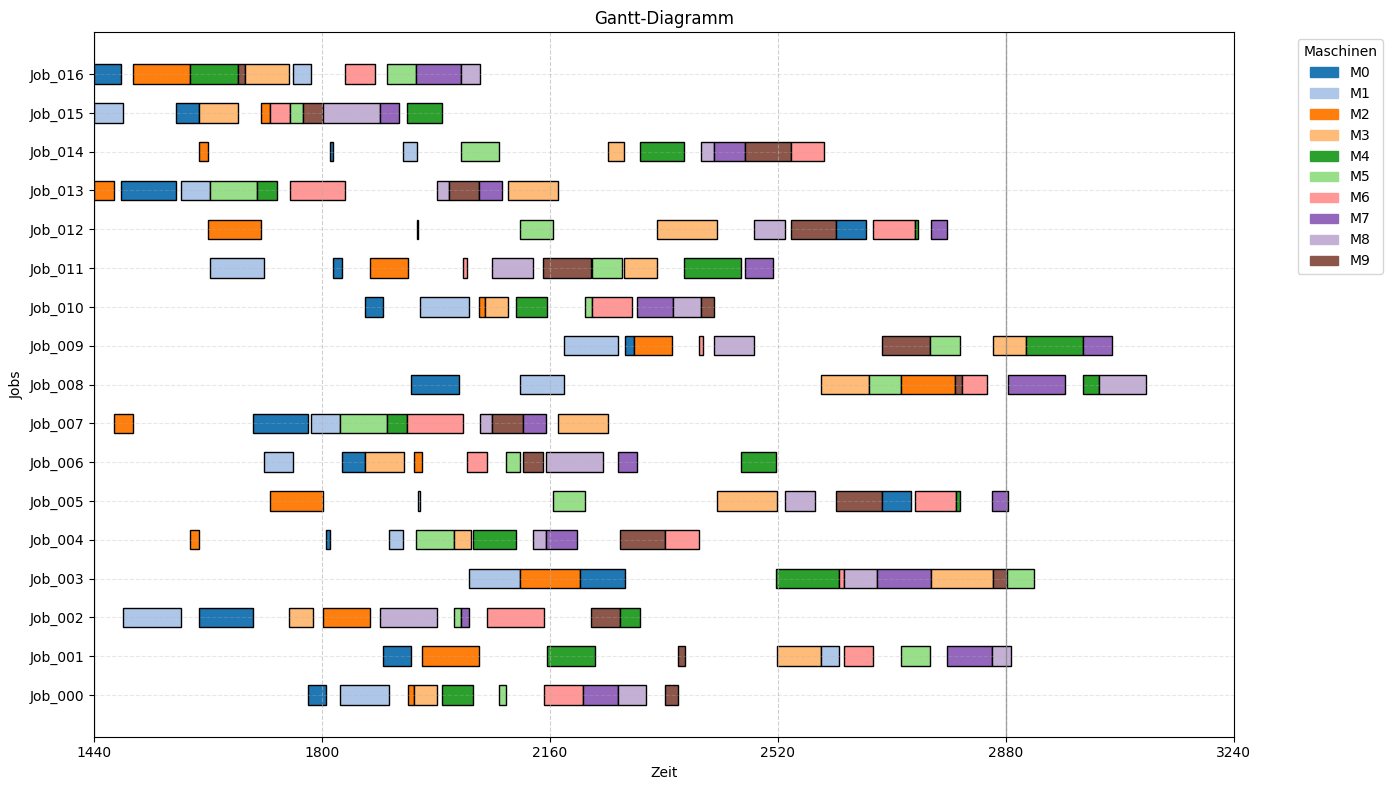

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [10]:
gantt.get_plot(df_plan, perspective="Machine")
check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

### B) Aufteilung in heutige und zukünftge Operationen

In [11]:
df_plan_for_sim = gen_jobs.filter_plan_for_today(df_plan, latest_op_start = day_end)
df_plan_for_sim

,Job,Operation,Machine,Start,Processing Time,End,Arrival,Deadline,Lateness,Tardiness,Earliness
0,Job_000,2,M2,1936,9,1945,0,2657,-712,0,712
1,Job_000,7,M7,2212,56,2268,0,2657,-389,0,389
2,Job_000,6,M6,2150,62,2212,0,2657,-445,0,445
3,Job_000,5,M5,2080,11,2091,0,2657,-566,0,566
4,Job_000,9,M9,2342,21,2363,0,2657,-294,0,294
...,...,...,...,...,...,...,...,...,...,...,...
159,Job_016,1,M2,1502,90,1592,1360,2543,-951,0,951
160,Job_016,7,M5,1902,46,1948,1360,2543,-595,0,595
161,Job_016,0,M0,1440,43,1483,1360,2543,-1060,0,1060
162,Job_016,3,M9,1667,11,1678,1360,2543,-865,0,865


In [12]:
df_plan_waiting = gen_jobs.filter_plan_for_future(df_plan, earliest_op_start = day_end)
df_plan_waiting

,Job,Operation,Machine,Start,Processing Time,End,Arrival,Deadline,Lateness,Tardiness,Earliness
0,Job_003,9,M5,2882,43,2925,157,5590,-2665,0,2665
1,Job_008,7,M7,2884,89,2973,870,7443,-4470,0,4470
2,Job_008,8,M4,3002,26,3028,870,7443,-4415,0,4415
3,Job_008,9,M8,3028,74,3102,870,7443,-4341,0,4341
4,Job_009,8,M4,2912,90,3002,885,18552,-15550,0,15550
5,Job_009,9,M7,3002,45,3047,885,18552,-15505,0,15505


### C) Simulation

In [13]:
simulation = ProductionDaySimulation(df_plan_for_sim, vc=0.25)
df_execution, df_plan_undone = simulation.run(start_time = day_start, end_time=day_end)

[24:00:00] Job_013 started on M2
[24:00:00] Job_015 started on M1
[24:00:00] Job_016 started on M0
[24:26:55] Job_013 finished on M2 (after 26 minutes 56 seconds)
[24:31:00] Job_007 started on M2
[24:48:05] Job_015 finished on M1 (after 48 minutes 06 seconds)
[24:48:05] Job_002 started on M1
[24:59:32] Job_016 finished on M0 (after 59 minutes 32 seconds)
[24:59:32] Job_013 started on M0
[25:04:04] Job_007 finished on M2 (after 33 minutes 04 seconds)
[25:04:04] Job_016 started on M2
[26:14:18] Job_013 finished on M0 (after 74 minutes 46 seconds)
[26:14:18] Job_015 started on M0
[26:44:05] Job_002 finished on M1 (after 115 minutes 59 seconds)
[26:44:05] Job_013 started on M1
[26:44:31] Job_016 finished on M2 (after 100 minutes 27 seconds)
[26:44:31] Job_004 started on M2
[26:44:31] Job_016 started on M4
[26:44:52] Job_015 finished on M0 (after 30 minutes 34 seconds)
[26:46:00] Job_002 started on M0
[26:46:00] Job_015 started on M3
[27:04:23] Job_004 finished on M2 (after 19 minutes 52 se

In [14]:
df_execution

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
0,Job_000,0,0,M0,1791.56,47.95,1839.51,1839.51
1,Job_000,1,0,M1,1894.73,148.91,2043.64,2043.64
2,Job_000,2,0,M2,2067.41,6.04,2073.45,2073.45
3,Job_000,3,0,M3,2073.45,27.98,2101.43,2101.43
4,Job_000,4,0,M4,2101.43,79.47,2180.90,2180.90
...,...,...,...,...,...,...,...,...
152,Job_016,5,1360,M1,1763.84,30.44,434.28,1794.28
153,Job_016,6,1360,M6,1852.63,64.90,557.53,1917.53
154,Job_016,7,1360,M5,1945.22,47.38,632.60,1992.60
155,Job_016,8,1360,M7,1997.54,58.79,696.33,2056.33


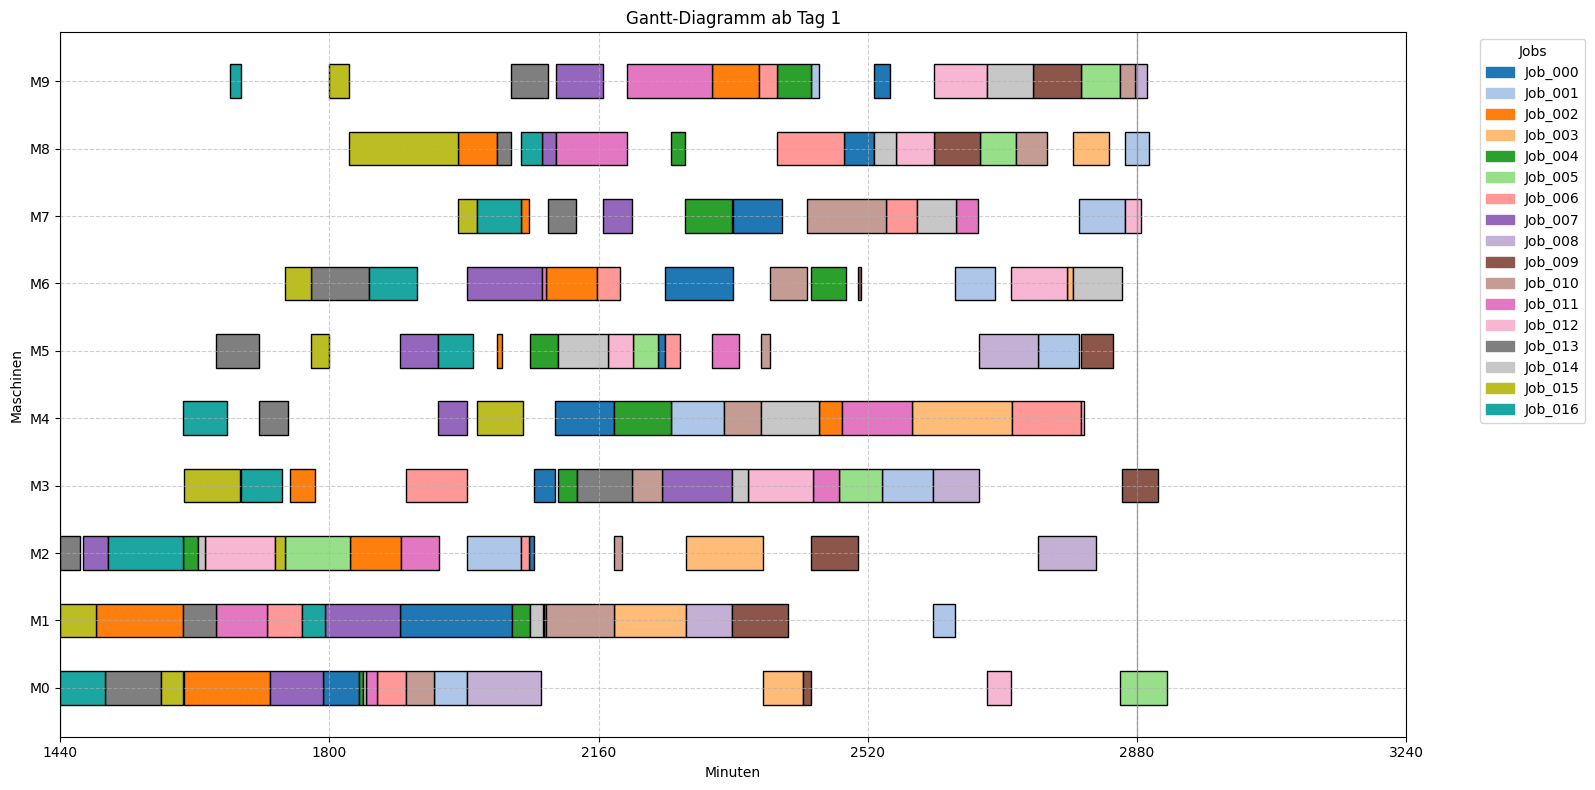

In [15]:
if not df_execution.empty:
    gantt.get_plot(
        df_execution, perspective="Machine",
        title=f"Gantt-Diagramm ab Tag {day_numb}", duration_column="Simulated Processing Time"
    )
else:
    print(f"Nothing executed on day {day_numb}")

In [16]:
df_plan_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
2,Job_003,6,157,M7,2677,85
3,Job_005,7,401,M6,2736,65
1,Job_003,7,157,M3,2762,98
5,Job_005,8,401,M4,2801,6
6,Job_008,6,870,M6,2811,40
4,Job_005,9,401,M7,2859,25
0,Job_003,8,157,M9,2860,22


## II) Tag 2

In [17]:
day_numb = 2

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [18]:
df_jobs_curr, df_ops_curr = gen_jobs.filter_ops_and_jobs_by_ready_time(df_jobs_times, df_jssp, ready_time = day_start)
df_jobs_curr

,Job,Arrival,Ready Time,Processing Time,Earliest End,Deadline
17,Job_017,1709,2880,568,3448,4594
18,Job_018,1762,2880,597,3477,4923
19,Job_019,1767,2880,655,3535,3928
20,Job_020,1777,2880,510,3390,9270
21,Job_021,1793,2880,496,3376,3988
...,...,...,...,...,...,...
34,Job_034,2524,2880,597,3477,3972
35,Job_035,2534,2880,496,3376,3647
36,Job_036,2542,2880,393,3273,4922
37,Job_037,2606,2880,539,3419,5806


### b) Operationen, die zuvor "ready" waren, aber noch nicht starten sollten

In [19]:
df_plan_waiting

,Job,Operation,Machine,Start,Processing Time,End,Arrival,Deadline,Lateness,Tardiness,Earliness
0,Job_003,9,M5,2882,43,2925,157,5590,-2665,0,2665
1,Job_008,7,M7,2884,89,2973,870,7443,-4470,0,4470
2,Job_008,8,M4,3002,26,3028,870,7443,-4415,0,4415
3,Job_008,9,M8,3028,74,3102,870,7443,-4341,0,4341
4,Job_009,8,M4,2912,90,3002,885,18552,-15550,0,15550
5,Job_009,9,M7,3002,45,3047,885,18552,-15505,0,15505


In [20]:
# Sicherstellen, dass beide DataFrames die Spalten 'Job' und 'Operation' haben
df_ops_waiting = df_jssp.merge(df_plan_waiting[["Job", "Operation"]], on=["Job", "Operation"], how="inner")
df_ops_waiting

,Job,Operation,Machine,Processing Time
0,Job_003,9,M5,43
1,Job_008,7,M7,89
2,Job_008,8,M4,26
3,Job_008,9,M8,74
4,Job_009,8,M4,90
5,Job_009,9,M7,45


In [21]:
df_jobs_waiting = df_jobs_times[df_jobs_times["Job"].isin(df_plan_waiting["Job"].unique())]
df_jobs_waiting

,Job,Arrival,Ready Time,Processing Time,Earliest End,Deadline
3,Job_003,157,1440,655,2095,5590
8,Job_008,870,1440,597,2037,7443
9,Job_009,885,1440,540,1980,18552


#### c) Unerledigte Operationen

In [22]:
df_plan_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
2,Job_003,6,157,M7,2677,85
3,Job_005,7,401,M6,2736,65
1,Job_003,7,157,M3,2762,98
5,Job_005,8,401,M4,2801,6
6,Job_008,6,870,M6,2811,40
4,Job_005,9,401,M7,2859,25
0,Job_003,8,157,M9,2860,22


In [23]:
# Sicherstellen, dass beide DataFrames die Spalten 'Job' und 'Operation' haben
df_ops_undone = df_jssp.merge(df_plan_undone[["Job", "Operation"]], on=["Job", "Operation"], how="inner")
df_ops_undone

,Job,Operation,Machine,Processing Time
0,Job_003,6,M7,85
1,Job_003,7,M3,98
2,Job_003,8,M9,22
3,Job_005,7,M6,65
4,Job_005,8,M4,6
5,Job_005,9,M7,25
6,Job_008,6,M6,40


In [24]:
df_jobs_undone = df_jobs_times[df_jobs_times["Job"].isin(df_ops_undone["Job"].unique())]
df_jobs_undone

,Job,Arrival,Ready Time,Processing Time,Earliest End,Deadline
3,Job_003,157,1440,655,2095,5590
5,Job_005,401,1440,496,1936,4808
8,Job_008,870,1440,597,2037,7443


### Zusammenführen

In [25]:
# Operationen
df_ops_curr_all = pd.concat([df_ops_curr, df_ops_waiting, df_ops_undone], ignore_index=True)
df_ops_curr_all = df_ops_curr_all.sort_values(by=["Job", "Operation"]).reset_index(drop=True)
df_ops_curr_all

,Job,Operation,Machine,Processing Time
0,Job_003,6,M7,85
1,Job_003,7,M3,98
2,Job_003,8,M9,22
3,Job_003,9,M5,43
4,Job_005,7,M6,65
...,...,...,...,...
228,Job_038,5,M8,52
229,Job_038,6,M7,85
230,Job_038,7,M3,98
231,Job_038,8,M9,22


In [26]:
df_jobs_curr_all = pd.concat([df_jobs_curr, df_jobs_waiting, df_jobs_undone], ignore_index=True)
df_jobs_curr_all = df_jobs_curr_all.drop_duplicates(subset="Job", keep="first").sort_values(by="Job").reset_index(drop=True)
df_jobs_curr_all

,Job,Arrival,Ready Time,Processing Time,Earliest End,Deadline
0,Job_003,157,1440,655,2095,5590
1,Job_005,401,1440,496,1936,4808
2,Job_008,870,1440,597,2037,7443
3,Job_009,885,1440,540,1980,18552
4,Job_017,1709,2880,568,3448,4594
...,...,...,...,...,...,...
21,Job_034,2524,2880,597,3477,3972
22,Job_035,2534,2880,496,3376,3647
23,Job_036,2542,2880,393,3273,4922
24,Job_037,2606,2880,539,3419,5806


### A) Rescheduling für Tag 2

In [40]:
import pandas as pd


def giffler_thompson_schedule2(
    df_jssp: pd.DataFrame,
    df_arrivals_deadlines: pd.DataFrame,
    priority_rule: str = "SPT",
    df_execution: pd.DataFrame = None,
    reschedule_start: float = 1440.0,
    log_on: bool = True
):
    if log_on:
        print(f"Giffler-Thompson mit Prioritätsregel '{priority_rule}' gestartet.\n")

    df = df_jssp.copy().sort_values(['Job', 'Operation']).reset_index(drop=True)
    machines = set(df['Machine'])
    jobs = df['Job'].unique()

    ready_time = df_arrivals_deadlines.set_index("Job")["Ready Time"].to_dict()
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()

    executed_ends = {}
    executed_last_op = {}
    fixed_machine_blocks = defaultdict(list)
    if df_execution is not None and not df_execution.empty:
        executed_ends = df_execution.groupby("Job")["End"].max().to_dict()
        executed_last_op = df_execution.groupby("Job")["Operation"].max().to_dict()
        for _, row in df_execution.iterrows():
            fixed_machine_blocks[row["Machine"]].append((row["Start"], row["End"]))

    job_op_index = {
        job: executed_last_op[job] + 1 if job in executed_last_op else 0
        for job in jobs
    }

    job_op_ready = {
        job: executed_ends[job] if job in executed_ends else 0
        for job in jobs
    }

    machine_available = {m: 0 for m in machines}

    job_ops = defaultdict(list)
    for _, row in df.iterrows():
        job_ops[row['Job']].append((row['Operation'], row['Machine'], row['Processing Time']))

    result = []
    while True:
        candidates = []
        for job in jobs:
            idx = job_op_index[job]
            if idx < len(job_ops[job]):
                op_id, m, d = job_ops[job][idx]

                base_time = max(reschedule_start, job_op_ready[job])
                est = max(machine_available[m], base_time)

                # Blockierende Maschinenzeiten berücksichtigen
                if m in fixed_machine_blocks:
                    while any(s <= est < e for s, e in fixed_machine_blocks[m]):
                        est = max(e for s, e in fixed_machine_blocks[m] if s <= est < e)

                # ✅ TECHNOLOGIE-PRÜFUNG: Ist Vorgänger eingeplant?
                if op_id > 0:
                    prev_end = None
                    for r in result:
                        if r["Job"] == job and r["Operation"] == op_id - 1:
                            prev_end = r["End"]
                            break
                    if prev_end is None and df_execution is not None and not df_execution.empty:
                        prev_df = df_execution[
                            (df_execution["Job"] == job) & (df_execution["Operation"] == op_id - 1)
                        ]
                        if not prev_df.empty:
                            prev_end = prev_df.iloc[0]["End"]

                    if prev_end is None:
                        continue  # Vorgänger nicht bekannt → überspringen

                    est = max(est, prev_end)

                candidates.append((est, d, job, op_id, m))

        if not candidates:
            if log_on:
                print("⚠️ Keine einplanbaren Kandidaten mehr – evtl. Vorgänger- oder Datenfehler.\n")
                for job in jobs:
                    idx = job_op_index[job]
                    if idx < len(job_ops[job]):
                        print(f"  Job {job} wartet auf Operation {idx}")
            break

        min_est = min(c[0] for c in candidates)
        conflict_ops = [c for c in candidates if c[0] == min_est]

        if priority_rule == "SPT":
            selected = min(conflict_ops, key=lambda x: x[1])
        elif priority_rule in ["EDF", "EDD"]:
            selected = min(conflict_ops, key=lambda x: deadline[x[2]])
        else:
            selected = random.choice(conflict_ops)

        est, d, job, op_id, m = selected
        start = est
        end = start + d

        result.append({
            'Job': job,
            'Operation': op_id,
            'Machine': m,
            'Start': start,
            'Processing Time': d,
            'End': end
        })

        job_op_ready[job] = end
        machine_available[m] = end
        job_op_index[job] += 1

    for row in result:
        job = row['Job']
        lateness_val = row['End'] - deadline[job]
        row.update({
            "Arrival": arrival[job],
            "Deadline": deadline[job],
            "Lateness": lateness_val,
            "Tardiness": max(0, lateness_val),
            "Earliness": max(0, -lateness_val)
        })

    df_schedule = pd.DataFrame(result)

    last_ops = df_schedule.groupby("Job")["Operation"].max()
    last_op_index_tuples = list(zip(last_ops.index, last_ops.values))
    mask_last_ops = df_schedule.set_index(["Job", "Operation"]).index.isin(last_op_index_tuples)
    total_abs_lateness = df_schedule[mask_last_ops]["Lateness"].abs().sum()
    makespan = df_schedule["End"].max()

    if df_execution is not None and not df_execution.empty:
        df_execution = df_execution.rename(columns={"Simulated Processing Time": "Processing Time"})
        df_mix = pd.concat([df_execution, df_schedule], ignore_index=True)
    else:
        df_mix = df_schedule.copy()

    # Diagnose: fehlende Operationen
    expected_ops = df.groupby("Job")["Operation"].count().to_dict()
    scheduled_ops = df_schedule.groupby("Job")["Operation"].count().to_dict()
    missing_jobs = {
        job: expected_ops[job] - scheduled_ops.get(job, 0)
        for job in expected_ops
        if expected_ops[job] != scheduled_ops.get(job, 0)
    }

    if log_on:
        print("\nPlan-Informationen:")
        print(f"  Anzahl Jobs            : {len(jobs)}")
        print(f"  Anzahl Maschinen       : {len(machines)}")
        print(f"  Anzahl Operationen     : {len(df_schedule)}")
        print(f"  Makespan               : {makespan}")
        print(f"  Summe Absolute Lateness: {total_abs_lateness}")
        if missing_jobs:
            print(f"\n⚠️ Fehlende Operationen:")
            for job, count in missing_jobs.items():
                print(f"  {job}: {count} nicht eingeplant")

    return df_schedule, makespan, total_abs_lateness, df_mix


In [45]:
import pandas as pd
import random
from collections import defaultdict

def giffler_thompson_schedule2(
    df_jssp: pd.DataFrame,
    df_arrivals_deadlines: pd.DataFrame,
    priority_rule: str = "SPT",
    df_execution: pd.DataFrame = None,
    reschedule_start: float = 1440.0,
    log_on: bool = True
):
    if log_on:
        print(f"Giffler-Thompson mit Prioritätsregel '{priority_rule}' gestartet.\n")

    df = df_jssp.copy().sort_values(['Job', 'Operation']).reset_index(drop=True)
    machines = set(df['Machine'])
    jobs = df['Job'].unique()

    ready_time = df_arrivals_deadlines.set_index("Job")["Ready Time"].to_dict()
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()

    executed_ends = {}
    executed_last_op = {}
    fixed_machine_blocks = defaultdict(list)
    if df_execution is not None and not df_execution.empty:
        executed_ends = df_execution.groupby("Job")["End"].max().to_dict()
        executed_last_op = df_execution.groupby("Job")["Operation"].max().to_dict()
        for _, row in df_execution.iterrows():
            fixed_machine_blocks[row["Machine"]].append((row["Start"], row["End"]))

    job_op_index = {
        job: executed_last_op[job] + 1 if job in executed_last_op else 0
        for job in jobs
    }

    job_op_ready = {
        job: executed_ends[job] if job in executed_ends else 0
        for job in jobs
    }

    machine_available = {m: 0 for m in machines}

    job_ops = defaultdict(list)
    for _, row in df.iterrows():
        job_ops[row['Job']].append((row['Operation'], row['Machine'], row['Processing Time']))

    result = []
    while True:
        candidates = []
        for job in jobs:
            idx = job_op_index[job]
            if idx < len(job_ops[job]):
                op_id, m, d = job_ops[job][idx]

                base_time = max(reschedule_start, job_op_ready[job])
                est = max(machine_available[m], base_time)

                if m in fixed_machine_blocks:
                    while any(s <= est < e for s, e in fixed_machine_blocks[m]):
                        est = max(e for s, e in fixed_machine_blocks[m] if s <= est < e)

                # ✅ Nur wenn df_execution vorhanden ist: Technologieprüfung
                if op_id > 0 and df_execution is not None and not df_execution.empty:
                    prev_end = None
                    for r in result:
                        if r["Job"] == job and r["Operation"] == op_id - 1:
                            prev_end = r["End"]
                            break
                    if prev_end is None:
                        prev_df = df_execution[
                            (df_execution["Job"] == job) & (df_execution["Operation"] == op_id - 1)
                        ]
                        if not prev_df.empty:
                            prev_end = prev_df.iloc[0]["End"]

                    if prev_end is None:
                        continue  # blockieren, aber nur bei aktivem df_execution

                    est = max(est, prev_end)

                candidates.append((est, d, job, op_id, m))

        if not candidates:
            if log_on:
                print("⚠️ Keine einplanbaren Kandidaten mehr – evtl. Vorgänger- oder Datenfehler.\n")
                for job in jobs:
                    idx = job_op_index[job]
                    if idx < len(job_ops[job]):
                        print(f"  Job {job} wartet auf Operation {idx}")
            break

        min_est = min(c[0] for c in candidates)
        conflict_ops = [c for c in candidates if c[0] == min_est]

        if priority_rule == "SPT":
            selected = min(conflict_ops, key=lambda x: x[1])
        elif priority_rule in ["EDF", "EDD"]:
            selected = min(conflict_ops, key=lambda x: deadline[x[2]])
        else:
            selected = random.choice(conflict_ops)

        est, d, job, op_id, m = selected
        start = est
        end = start + d

        result.append({
            'Job': job,
            'Operation': op_id,
            'Machine': m,
            'Start': start,
            'Processing Time': d,
            'End': end
        })

        job_op_ready[job] = end
        machine_available[m] = end
        job_op_index[job] += 1

    for row in result:
        job = row['Job']
        lateness_val = row['End'] - deadline[job]
        row.update({
            "Arrival": arrival[job],
            "Deadline": deadline[job],
            "Lateness": lateness_val,
            "Tardiness": max(0, lateness_val),
            "Earliness": max(0, -lateness_val)
        })

    df_schedule = pd.DataFrame(result)

    last_ops = df_schedule.groupby("Job")["Operation"].max()
    last_op_index_tuples = list(zip(last_ops.index, last_ops.values))
    mask_last_ops = df_schedule.set_index(["Job", "Operation"]).index.isin(last_op_index_tuples)
    total_abs_lateness = df_schedule[mask_last_ops]["Lateness"].abs().sum()
    makespan = df_schedule["End"].max()

    if df_execution is not None and not df_execution.empty:
        df_execution = df_execution.rename(columns={"Simulated Processing Time": "Processing Time"})
        df_mix = pd.concat([df_execution, df_schedule], ignore_index=True)
    else:
        df_mix = df_schedule.copy()

    # Diagnose: fehlende Operationen
    expected_ops = df.groupby("Job")["Operation"].count().to_dict()
    scheduled_ops = df_schedule.groupby("Job")["Operation"].count().to_dict()
    missing_jobs = {
        job: expected_ops[job] - scheduled_ops.get(job, 0)
        for job in expected_ops
        if expected_ops[job] != scheduled_ops.get(job, 0)
    }

    if log_on:
        print("\nPlan-Informationen:")
        print(f"  Anzahl Jobs            : {len(jobs)}")
        print(f"  Anzahl Maschinen       : {len(machines)}")
        print(f"  Anzahl Operationen     : {len(df_schedule)}")
        print(f"  Makespan               : {makespan}")
        print(f"  Summe Absolute Lateness: {total_abs_lateness}")
        if missing_jobs:
            print(f"\n⚠️ Fehlende Operationen:")
            for job, count in missing_jobs.items():
                print(f"  {job}: {count} nicht eingeplant")

    return df_schedule, makespan, total_abs_lateness, df_mix


In [46]:
# Reduktion der bereits ausgeführten Operationen, die im heutigen Plan hineinlaufen
df_execution_important = df_execution[df_execution["End"] >= day_start]
df_execution_important

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
19,Job_001,9,48,M8,2863.54,32.72,2848.26,2896.26
52,Job_005,6,401,M0,2856.93,63.34,2519.27,2920.27
78,Job_008,5,870,M9,2877.44,15.50,2022.94,2892.94
86,Job_009,7,885,M3,2860.00,48.02,2023.02,2908.02
116,Job_012,9,980,M7,2863.54,21.58,1905.12,2885.12


In [47]:
df_plan2, makespan, total_abs_lateness, df_mix = giffler_thompson_schedule2(
    df_jssp=df_ops_curr_all,
    df_arrivals_deadlines=df_jobs_curr_all,
    priority_rule="EDF",
    df_execution=None,
    reschedule_start = 2880,
    log_on=True
)

Giffler-Thompson mit Prioritätsregel 'EDF' gestartet.

⚠️ Keine einplanbaren Kandidaten mehr – evtl. Vorgänger- oder Datenfehler.


Plan-Informationen:
  Anzahl Jobs            : 26
  Anzahl Maschinen       : 10
  Anzahl Operationen     : 233
  Makespan               : 4943
  Summe Absolute Lateness: 49556


In [56]:
missing_jobs = set(df_jobs_curr_all['Job']) - set(df_ops_curr_all['Job'])
print("Fehlende Jobs im df_jssp:", missing_jobs)

Fehlende Jobs im df_jssp: set()


In [48]:
last_ops = df_plan2.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
show.count_column_grouped(last_ops, "Tardiness", max_val = 840, steps= 120)

label
0            26
0 - 120       0
120 - 240     0
240 - 360     0
360 - 480     0
480 - 600     0
600 - 720     0
720 - 840     0
>840          0
Name: count, dtype: int64

In [49]:
# Kombinierten Plan erzeugen durch einfaches Zusammenfügen
df_execution = df_execution.rename(columns={"Simulated Processing Time": "Processing Time"})
df_mix = pd.concat([df_execution, df_plan2], ignore_index=True)
df_mix

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End,Deadline,Lateness,Tardiness,Earliness
0,Job_000,0,0,M0,1791.56,47.95,1839.51,1839.51,NaN,NaN,NaN,NaN
1,Job_000,1,0,M1,1894.73,148.91,2043.64,2043.64,NaN,NaN,NaN,NaN
2,Job_000,2,0,M2,2067.41,6.04,2073.45,2073.45,NaN,NaN,NaN,NaN
3,Job_000,3,0,M3,2073.45,27.98,2101.43,2101.43,NaN,NaN,NaN,NaN
4,Job_000,4,0,M4,2101.43,79.47,2180.90,2180.90,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
385,Job_022,9,1840,M7,4780.00,45.00,NaN,4825.00,5823.0,-998.0,0.0,998.0
386,Job_024,7,1942,M3,4780.00,98.00,NaN,4878.00,7937.0,-3059.0,0.0,3059.0
387,Job_023,9,1891,M8,4785.00,74.00,NaN,4859.00,7052.0,-2193.0,0.0,2193.0
388,Job_024,8,1942,M9,4878.00,22.00,NaN,4900.00,7937.0,-3037.0,0.0,3037.0


In [50]:
df_execution[df_execution.Job == "Job_009"]

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
79,Job_009,0,885,M1,2338.50,75.38,1528.88,2413.88
80,Job_009,1,885,M0,2433.46,10.48,1558.94,2443.94
81,Job_009,2,885,M2,2443.94,63.21,1622.15,2507.15
82,Job_009,3,885,M6,2507.15,4.07,1626.22,2511.22
83,Job_009,4,885,M8,2609.04,61.53,1785.57,2670.57
84,Job_009,5,885,M9,2740.33,64.88,1920.21,2805.21
85,Job_009,6,885,M5,2805.21,43.31,1963.52,2848.52
86,Job_009,7,885,M3,2860.00,48.02,2023.02,2908.02


In [51]:
df_execution[df_execution.Job == "Job_009"]

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
79,Job_009,0,885,M1,2338.50,75.38,1528.88,2413.88
80,Job_009,1,885,M0,2433.46,10.48,1558.94,2443.94
81,Job_009,2,885,M2,2443.94,63.21,1622.15,2507.15
82,Job_009,3,885,M6,2507.15,4.07,1626.22,2511.22
83,Job_009,4,885,M8,2609.04,61.53,1785.57,2670.57
84,Job_009,5,885,M9,2740.33,64.88,1920.21,2805.21
85,Job_009,6,885,M5,2805.21,43.31,1963.52,2848.52
86,Job_009,7,885,M3,2860.00,48.02,2023.02,2908.02


In [52]:
df_plan2[df_plan2.Job == "Job_009"]

,Job,Operation,Machine,Start,Processing Time,End,Arrival,Deadline,Lateness,Tardiness,Earliness
5,Job_009,8,M4,2880,90,2970,885,18552,-15582,0,15582
13,Job_009,9,M7,2970,45,3015,885,18552,-15537,0,15537


In [53]:
df_ops_curr_all[df_ops_curr_all.Job == "Job_009"]

,Job,Operation,Machine,Processing Time
11,Job_009,8,M4,90
12,Job_009,9,M7,45


In [54]:
df_mix[df_mix.Job == "Job_009"]

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End,Deadline,Lateness,Tardiness,Earliness
79,Job_009,0,885,M1,2338.50,75.38,1528.88,2413.88,NaN,NaN,NaN,NaN
80,Job_009,1,885,M0,2433.46,10.48,1558.94,2443.94,NaN,NaN,NaN,NaN
81,Job_009,2,885,M2,2443.94,63.21,1622.15,2507.15,NaN,NaN,NaN,NaN
82,Job_009,3,885,M6,2507.15,4.07,1626.22,2511.22,NaN,NaN,NaN,NaN
83,Job_009,4,885,M8,2609.04,61.53,1785.57,2670.57,NaN,NaN,NaN,NaN
84,Job_009,5,885,M9,2740.33,64.88,1920.21,2805.21,NaN,NaN,NaN,NaN
85,Job_009,6,885,M5,2805.21,43.31,1963.52,2848.52,NaN,NaN,NaN,NaN
86,Job_009,7,885,M3,2860.00,48.02,2023.02,2908.02,NaN,NaN,NaN,NaN
162,Job_009,8,885,M4,2880.00,90.00,NaN,2970.00,18552.0,-15582.0,0.0,15582.0
170,Job_009,9,885,M7,2970.00,45.00,NaN,3015.00,18552.0,-15537.0,0.0,15537.0


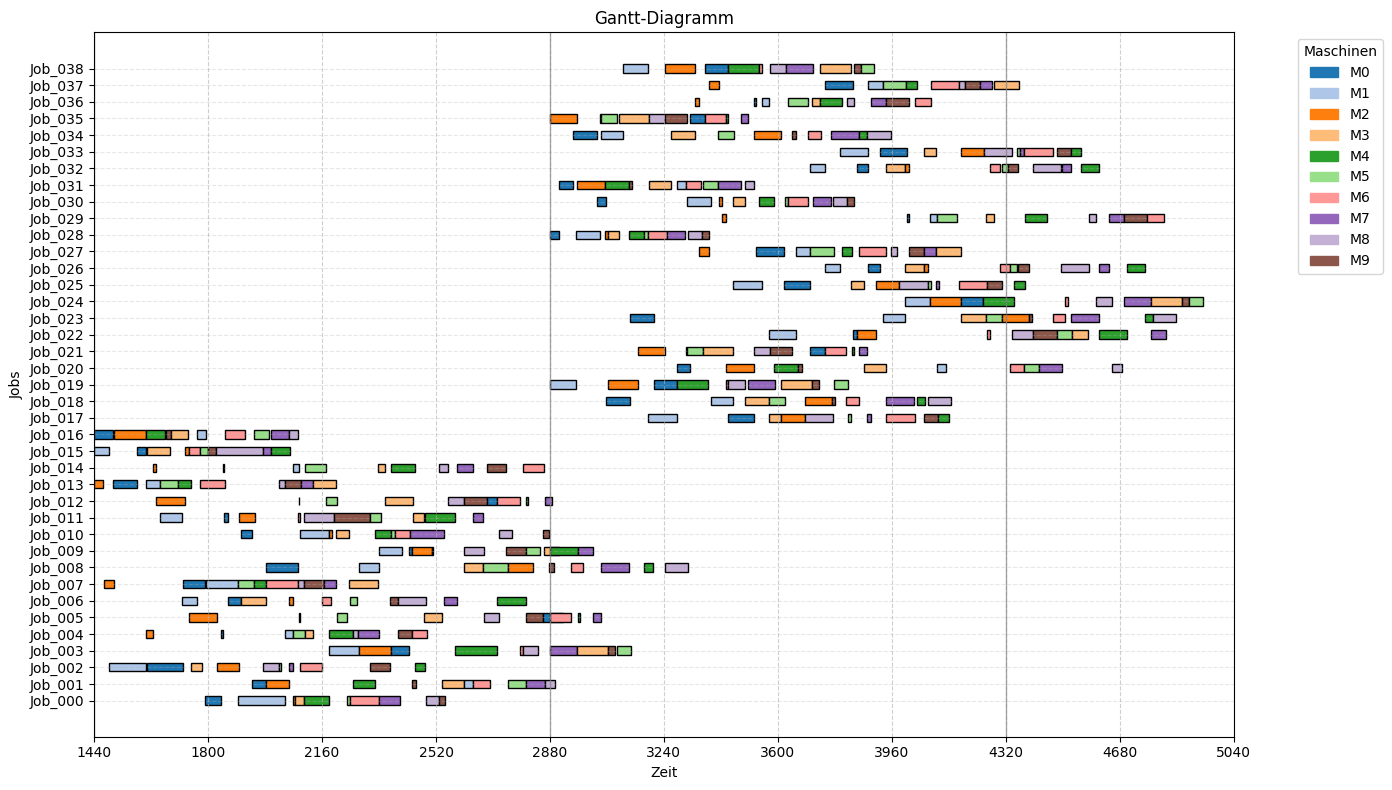

- Maschinenkonflikte gefunden: 4 Zeilen betroffen.
         Job  Operation  Arrival Machine    Start  Processing Time  Flow time  \
52   Job_005          6      401      M0  2856.93            63.34    2519.27   
157  Job_028          0     2109      M0  2880.00            29.00        NaN   
116  Job_012          9      980      M7  2863.54            21.58    1905.12   
161  Job_003          6      157      M7  2880.00            85.00        NaN   

         End  Deadline  Lateness  Tardiness  Earliness  
52   2920.27       NaN       NaN        NaN        NaN  
157  2909.00    3615.0    -706.0        0.0      706.0  
116  2885.12       NaN       NaN        NaN        NaN  
161  2965.00    5590.0   -2625.0        0.0     2625.0  
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
- 2 Verletzung(en) der technologischen Reihenfolge gefunden:
  Job 'Job_005', Operation 7: Start=2880, aber vorherige Operation endete erst bei 2920
  Job 'Job_009', Operation 8: Start=2880, a

True

In [55]:
gantt.get_plot(df_mix, perspective="Job")

check.is_machine_conflict_free(df_mix)
check.is_operation_sequence_correct(df_mix)
check.is_job_timing_correct(df_mix)
check.is_start_correct(df_mix)